# Exercises Hand-In 2
## Group 30 (Oliver Nilsson)

In [1]:
# Import required libraries
import pandas as pd
import requests as req
import bs4
import re
import time
import folium
from math import radians, sin, cos, sqrt, atan2
import seaborn as sns
import matplotlib.pyplot as plt

# Print the versions of the libraries to check if they are installed correctly
print(f"Pandas version: {pd.__version__}")
print(f"Requests version: {req.__version__}")
print (f"BeautifulSoup version: {bs4.__version__}")
print(f"Regular Expression version: {re.__version__}")
print(f"Time import status ok if response: {time}")
print(f"Folium version: {folium.__version__}")
print(f"Math import status ok if response: {radians, sin, cos, sqrt, atan2}")
print(f"Seaborn version: {sns.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Pandas version: 1.5.3
Requests version: 2.31.0
BeautifulSoup version: 4.12.3
Regular Expression version: 2.2.1
Time import status ok if response: <module 'time' (built-in)>
Folium version: 0.16.0
Math import status ok if response: (<built-in function radians>, <built-in function sin>, <built-in function cos>, <built-in function sqrt>, <built-in function atan2>)
Seaborn version: 0.13.2
Matplotlib version: 3.8.4


## 2. Booli scraping

In [2]:
# Define the base address and the start address
base_address = 'https://www.booli.se/'
start_address = base_address + 'sok/slutpriser?areaIds=115329&maxSoldDate=2024-05-15&minSoldDate=2024-01-01&rooms=2,1'

# Test response, should return 200 if request was successful
# Use try-except to catch any errors and prevent the script from crashing
try:
    response = req.get(start_address)
    response.raise_for_status()
    print(f"Response code: {response.status_code}")
except req.exceptions.HTTPError as err:
    print(err)

Response code: 200


In [3]:
# Parse the response with BeautifulSoup
soup = bs4.BeautifulSoup(response.content, 'lxml')

# Define function for finding the objects
def get_objects(soup):
    objs = soup.find_all('li', {'class': 'search-page__module-container'})
    apartments = [] # Empty list to store the apartments

    # Loop through the objects and extract the relevant information
    for obj in objs:
        div = obj.find('div', {'class': 'object-card__content sm:pb-3'})
        if div:
            text_elements = list(div.stripped_strings)
            apartment = {}
            # Loop through the text elements and extract the relevant information with error handling to prevent crashes
            for element in text_elements:
                if 'vån\xa0' in element:
                    try:
                        apartment['floor'] = int(element.lstrip('vån\xa0'))
                    except ValueError:
                        apartment['floor'] = None
                elif 'kr' in element:
                    try:
                        apartment['price'] = int(element.replace('\xa0', '').strip('kr').replace(' ', ''))
                    except ValueError:
                        apartment['price'] = None
                elif 'm²' in element:
                    try:
                        area = element.replace('m²', '').replace('\xa0m²', '').strip()
                        apartment['area'] = float(area.replace('½', '')) + 0.5 if '½' in element else float(area)
                    except ValueError:
                        apartment['area'] = None
                elif '\xa0rum' in element:
                    try:
                        rooms = element.replace('½', '').rstrip('\xa0rum').strip()
                        apartment['rooms'] = float(rooms) + 0.5 if '½' in element else float(rooms)
                    except ValueError:
                        apartment['rooms'] = None
                else:
                    # Address and date are the first two elements assumed by their order
                    apartment['address'] = text_elements[0] if len(text_elements) > 0 else None
                    apartment['date'] = text_elements[1] if len(text_elements) > 1 else None
                    apartment['city'] = text_elements[2].split('·')[-1].strip() if len(text_elements) > 2 else None
            apartments.append(apartment) # Append the apartment to the list of apartments
    return apartments # Return the list of apartments to the function caller

def get_coords(address, city):
    nomi = 'https://nominatim.openstreetmap.org/search?'
    full_address = address + ', ' + city # Combine the address and city to get the full address
    params = {'q': full_address, 'format': 'json', 'limit': 1} 
    r = req.get(nomi, params = params)
    time.sleep(1.5) # Sleep for 1.5 seconds to avoid getting blocked by the server
    try:
        lat_lon = (r.json()[0]['lat'], r.json()[0]['lon']) # Get the latitude and longitude from the JSON response
    except IndexError:
        lat_lon = (None, None)
    return lat_lon

In [4]:
# Use the function to get the list of apartments
apartments = pd.DataFrame(get_objects(soup)) # Create a DataFrame from the list of apartments
apartments.head() # Print the first 5 rows of the DataFrame to check if the data is correct

,address,date,city,price,area,rooms,floor
0,Kjellmansgatan 26,2024-05-15,Göteborg,3900000,51.0,2.0,6.0
1,Masthuggsliden 14,2024-05-14,Göteborg,2100000,42.0,1.0,1.0
2,Olivedalsgatan 18,2024-05-11,Göteborg,4800000,56.0,2.0,4.0
3,Slottsskogsgatan 113,2024-05-13,Göteborg,2800000,50.0,2.0,2.0
4,Skytteskogsgatan 48,2024-05-13,Göteborg,2925000,50.0,2.0,2.0


In [5]:
# Adding all pages from Booli to the DataFrame
while True:
    next_page = [x for x in soup.find_all('a') if x.string == 'Nästa sida'] # Find the next page link
    # If the next page link is found, get the link and parse the response with BeautifulSoup
    if next_page:
        next_page = base_address + next_page[0]['href'] # Get the link for the next page
        response = req.get(next_page) # Get the response for the next page
        soup = bs4.BeautifulSoup(response.content, 'lxml') # Parse the response with BeautifulSoup
        apartments = pd.concat([apartments, pd.DataFrame(get_objects(soup))], ignore_index=True) # Add the new apartments to the DataFrame
    else:
        break
    time.sleep(3) # Sleep for 3 seconds to avoid getting blocked by the server

In [6]:
# Add price per square meter
apartments['price_per_sqm'] = apartments['price'] / apartments['area']

In [7]:
# Add coordinates
apartments['lat'], apartments['lon'] = zip(*apartments.apply(lambda row: get_coords(row['address'], row['city']), axis=1))

# Convert latitude and longitude columns to numeric type
apartments['lat'] = pd.to_numeric(apartments['lat'], errors='coerce')
apartments['lon'] = pd.to_numeric(apartments['lon'], errors='coerce')

# Print the first 5 rows of the DataFrame to check if the data is correct
apartments.head()

,address,date,city,price,area,rooms,floor,price_per_sqm,lat,lon
0,Kjellmansgatan 26,2024-05-15,Göteborg,3900000,51.0,2.0,6.0,76470.588235,57.698388,11.937571
1,Masthuggsliden 14,2024-05-14,Göteborg,2100000,42.0,1.0,1.0,50000.000000,57.696593,11.942692
2,Olivedalsgatan 18,2024-05-11,Göteborg,4800000,56.0,2.0,4.0,85714.285714,57.691918,11.954479
3,Slottsskogsgatan 113,2024-05-13,Göteborg,2800000,50.0,2.0,2.0,56000.000000,57.681496,11.933856
4,Skytteskogsgatan 48,2024-05-13,Göteborg,2925000,50.0,2.0,2.0,58500.000000,57.681077,11.934433


In [8]:
# Create map with apartments mean coordinates as the center
map_center = (apartments['lat'].mean(), apartments['lon'].mean())

# Create a map with the mean coordinates as the center and a zoom level of 13
map_osm = folium.Map(location=map_center, zoom_start=13)

# Add a marker for each apartment to the map
for index, row in apartments.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['address']).add_to(map_osm)

map_osm.save('map.html') # Save the map to an HTML file
print('Map saved to map.html') # Print a message to the console to inform the user that the map was saved

Map saved to map.html


In [9]:
# Coordinates to Handelshögskolan vid Göteborgs universitet is 57.6973808, 11.9617214
# Calculate distance in kilometers between two coordinates using Harversine formula

# Haversine function, set default coordinates to Handelshögskolan vid Göteborgs universitet
def haversine(lat2, lon2, lat1=57.6973808, lon1=11.9617214):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = 6371 * c # Earth radius in kilometers
    return distance

In [10]:
# Add distance_to_school column to the DataFrame
apartments['distance_to_school'] = apartments.apply(lambda row: haversine(row['lat'], row['lon']), axis=1)

# Print the first 5 rows of the DataFrame to check if the data is correct
apartments.head()

,address,date,city,price,area,rooms,floor,price_per_sqm,lat,lon,distance_to_school
0,Kjellmansgatan 26,2024-05-15,Göteborg,3900000,51.0,2.0,6.0,76470.588235,57.698388,11.937571,1.439417
1,Masthuggsliden 14,2024-05-14,Göteborg,2100000,42.0,1.0,1.0,50000.000000,57.696593,11.942692,1.134130
2,Olivedalsgatan 18,2024-05-11,Göteborg,4800000,56.0,2.0,4.0,85714.285714,57.691918,11.954479,0.744415
3,Slottsskogsgatan 113,2024-05-13,Göteborg,2800000,50.0,2.0,2.0,56000.000000,57.681496,11.933856,2.421310
4,Skytteskogsgatan 48,2024-05-13,Göteborg,2925000,50.0,2.0,2.0,58500.000000,57.681077,11.934433,2.432557


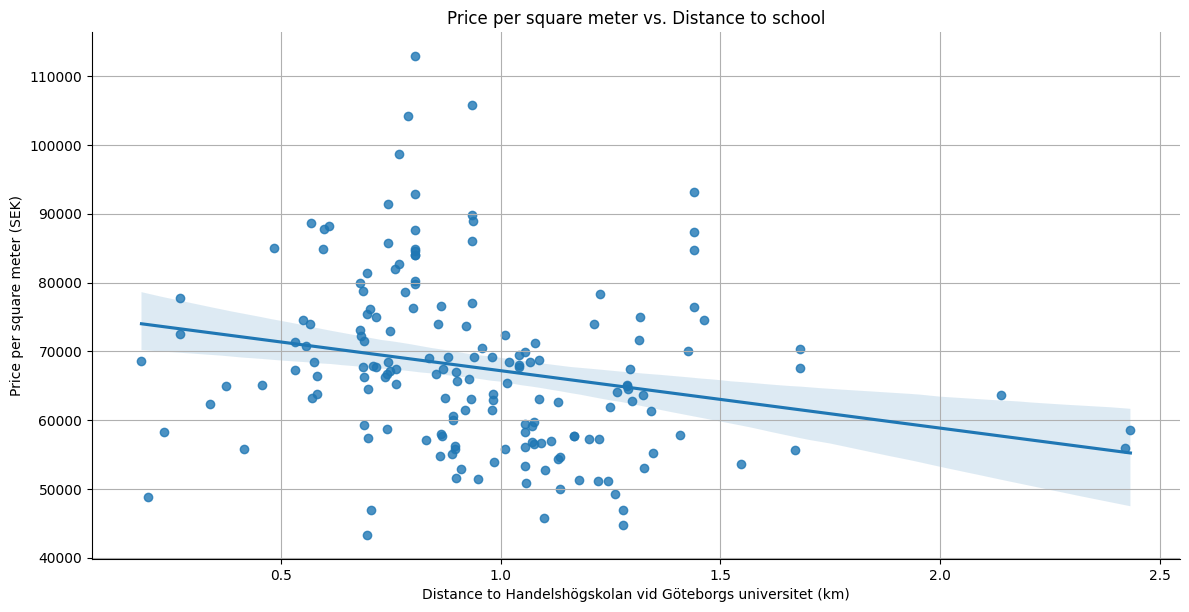

In [11]:
# Plot the price per square meter vs. distance to school
sns.lmplot(x='distance_to_school', y='price_per_sqm', data=apartments, aspect=2, height=6)
plt.title('Price per square meter vs. Distance to school')
plt.xlabel('Distance to Handelshögskolan vid Göteborgs universitet (km)')
plt.ylabel('Price per square meter (SEK)')
plt.grid(True)
plt.show()

We can see a somewhat weak relationship between Price per square meter (SEK) and Distance to the Handelshögskolan vid Göteborgs universitet (km) in sold apartments within Linnéstaden, which indicates that the proximity to the university has a certain influence on property prices in this area.

In [12]:
# Generate Excel file with the data with error handling to prevent crashes
try:
    apartments.to_excel('apartments.xlsx', index=False)
    print("Excel file apartments.xlsx created successfully")
except Exception as e:
    print(f"Error: {e}")

Excel file apartments.xlsx created successfully
